# Hourly PSDS - IROMY

## Load Libraries

In [33]:
import os
import pickle
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path

from functions.get_fband_average import __get_fband_average

In [6]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [2]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero

    min_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])

    return min_psd

In [3]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [4]:
def __get_minimum_psd(psds, f_tmp):

    for i, psd in enumerate(psds):
        if i == 0:
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum()

        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    return psds[idx]

In [5]:
def __get_array_from_dataframe(df):

    from pandas import to_numeric

    ## convert to list
    psds = []
    for col in array(df.columns):

        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

## Configurations

In [18]:
## ---------------------------------------

name = "PROMY"
inname = "2023_PROMY_3600"
subdir = "PROMY/"
threshold = 1e8
f_limits = 0.001, 1.0

d1, d2 = "2023-11-04", "2023-11-05"

## ---------------------------------------

path = data_path+f"LNM2/PSDS/"

## load configurations
config = pickle.load(open(path+subdir+inname+"_config.pkl", 'rb'))

config['inname'] = inname
config['inpath'] = path+subdir
config['f_limits'] = f_limits
config['thres'] = threshold
config['station'] = name

config['outpath_figures'] = data_path+f"LNM2/figures/"

config['period_limits'] = [1/config['f_limits'][1], 1/config['f_limits'][0]]


## Methods

In [19]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [20]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    psds_hourly = read_pickle(path+file)

    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

In [21]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [22]:
def __remove_noisy_psds(arr, threshold_mean=1e-16):

    from numpy import delete, shape, sort, array

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if arr[ii,:].mean() > threshold_mean:
            rejected.append(arr[ii,:])
            idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii,:].mean() < 1e-26:
            rejected.append(arr[ii,:])
            idx_to_remove.append(ii)

    for jj in sort(array(idx_to_remove))[::-1]:
        arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [42]:
def __makeplot_colorlines(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)



    ##____________________________


    fig, axes = plt.subplots(1, 1, figsize=(15,7), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24
    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for n, psd in enumerate(psds):
        axes.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = axes.scatter(ff[0], psd[0], s=0.1, c=int(n/N), cmap=cmap, vmin=0, vmax=N)

    for reject in rejected:
         axes.loglog(ff, reject, color='grey', alpha=0.6, zorder=1)

    axes.loglog(ff, __get_median_psd(psds), 'black', zorder=3, alpha=0.6, label="Median")

    axes.grid(True, which="both", ls="-", alpha=0.5)
    axes.legend(loc='lower left')
    axes.tick_params(labelsize=font-2)

    axes.set_ylim(1e-11, 1e2)
    axes.set_xlim(1e-3, 2e1)

    axes.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)


    # axes.set_ylabel(r"PSD$_{absolute}$ ($hPa$/$Hz)$", fontsize=font)
    axes.set_ylabel(r"PSD ($Pa^2$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes, aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))

    axes.set_title(f"{config['station']} | {day}")

    plt.show();
    return fig

## RUN for all files 

In [43]:
config['files'] = [file for file in os.listdir(config['inpath']) if "hourly" in file]
config['files'].sort()

In [44]:
config['files']

['2023_PROMY_3600_20230922_hourly.pkl',
 '2023_PROMY_3600_20230923_hourly.pkl',
 '2023_PROMY_3600_20230924_hourly.pkl',
 '2023_PROMY_3600_20230925_hourly.pkl',
 '2023_PROMY_3600_20230926_hourly.pkl',
 '2023_PROMY_3600_20230927_hourly.pkl',
 '2023_PROMY_3600_20230928_hourly.pkl',
 '2023_PROMY_3600_20230929_hourly.pkl',
 '2023_PROMY_3600_20230930_hourly.pkl',
 '2023_PROMY_3600_20231001_hourly.pkl',
 '2023_PROMY_3600_20231002_hourly.pkl',
 '2023_PROMY_3600_20231003_hourly.pkl',
 '2023_PROMY_3600_20231004_hourly.pkl',
 '2023_PROMY_3600_20231005_hourly.pkl',
 '2023_PROMY_3600_20231006_hourly.pkl',
 '2023_PROMY_3600_20231007_hourly.pkl',
 '2023_PROMY_3600_20231008_hourly.pkl',
 '2023_PROMY_3600_20231009_hourly.pkl',
 '2023_PROMY_3600_20231010_hourly.pkl',
 '2023_PROMY_3600_20231011_hourly.pkl',
 '2023_PROMY_3600_20231012_hourly.pkl',
 '2023_PROMY_3600_20231013_hourly.pkl',
 '2023_PROMY_3600_20231014_hourly.pkl',
 '2023_PROMY_3600_20231104_hourly.pkl',
 '2023_PROMY_3600_20231105_hourly.pkl']

 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


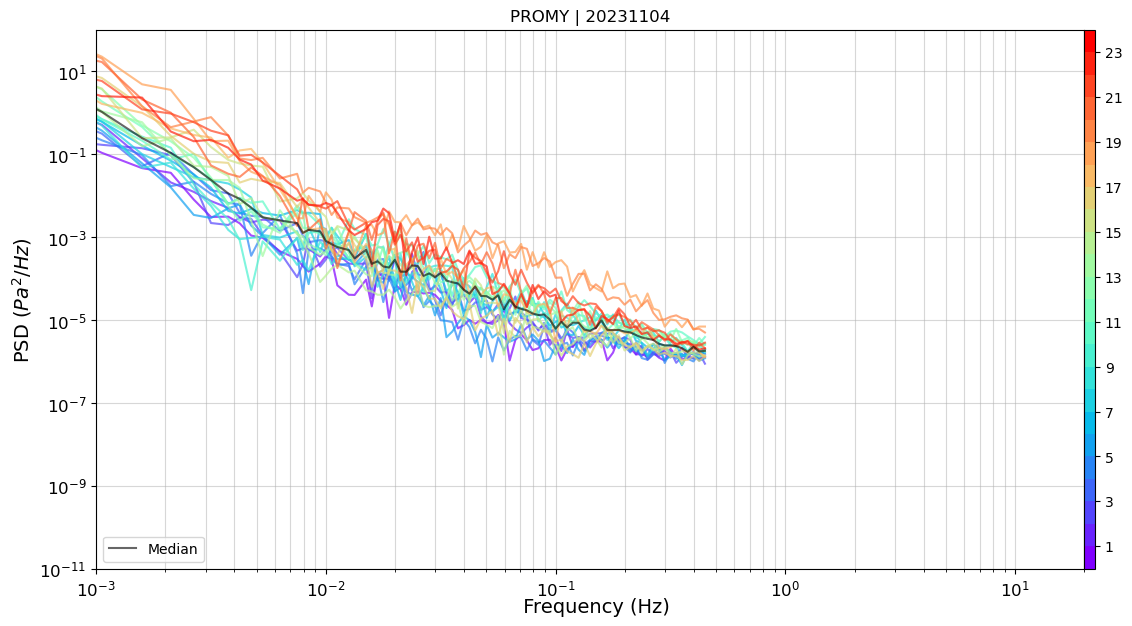

 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


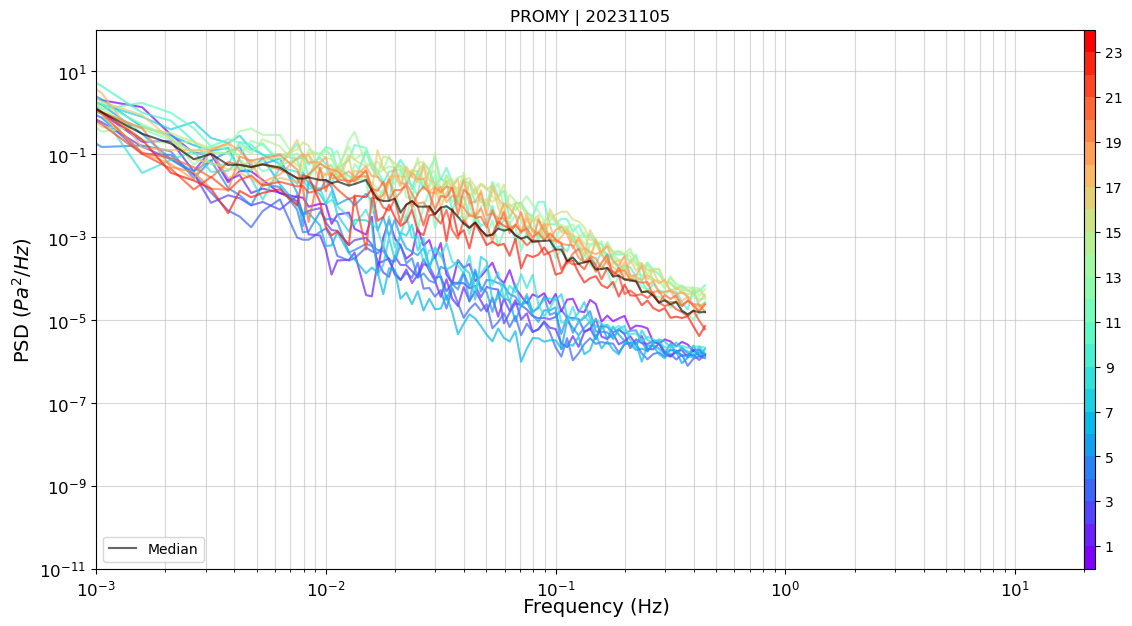

In [45]:
psds_medians_out, times_out = [], []

for _i, day in enumerate(date_range(d1, d2)):

    ## modify day string
    day = str(day).split(" ")[0].replace("-", "")

    ## specify output name
    config['outpath_figname'] = config['station']+"_"+day

    ## assemble file name
    file = f"{day[:4]}_{config['station']}_3600_{day}_hourly.pkl"

    ## skip if file does not exist
    if not os.path.isfile(config['inpath']+file):
        print(f" -> skipping {file} ...")
        continue

    ## load frequency axis data
    _ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pkl", 'rb'))

    ## load psd data
    _psd = __load_data_file(config['inpath'], file)

    ## cut psd data for frequency limits
    # _psd, _ff = __cut_frequencies_array(_psd, _ff, config['frequency_limits'][0], config['frequency_limits'][1])

    ## remove noise psds
    _psd, rejected = __remove_noisy_psds(_psd, threshold_mean=config['thres'])

    ## get fband averages
    psds = []
    for _n, _psd in enumerate(_psd):
        out0 = __get_fband_average(_ff, _psd, faction_of_octave=12 , average="median", plot=False)
        psds.append(out0['psd_means'])
    ff = out0['fcenter']
    psds = array(psds)

    ## make plot with colorlines
    fig = __makeplot_colorlines(config, ff,  psds, rejected, day)

    ## save plot
    fig.savefig(config['outpath_figures']+config['outpath_figname']+".png", format="png", transparent=False)


In [32]:
    ## output data
#     psds_medians_out.append(psds_median)
#     times_out.append(time)

# ## write output
# output = {"times": array(times_out).astype(int), "frequencies": array(ff), "psds_medians": array(psds_medians_out)}

# with open(f"{config['inpath']}{config['inname']}_psds_filtered_medians.pkl", 'wb') as file:
#     pickle.dump(output, file, protocol=pickle.HIGHEST_PROTOCOL)